# PS Anndata for All Cells

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


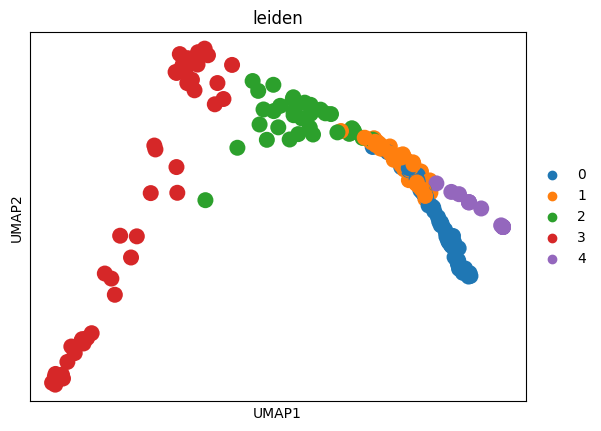

In [2]:
adata = ad.read_zarr('/mnt/ssd/atlases/Human_Atlas_Harmonised.zarr')
ps_bulk_adata = sc.read_h5ad('../ps_bulk_adata.h5ad')
sc.pl.umap(ps_bulk_adata, color='leiden')

In [4]:
ps_bulk_adata.obs.Dataset.value_counts()
leiden_map = dict(zip(ps_bulk_adata.obs.Dataset_ID, ps_bulk_adata.obs.leiden))

# leiden_map

In [5]:
adata.obs['Dataset_ID'] = adata.obs.Dataset.astype(str) + '_' + adata.obs.Sample_ID.astype(str)
composition = pd.crosstab(adata.obs['Dataset_ID'], adata.obs['Level_4'])
composition_prop = composition.div(composition.sum(axis=1), axis=0) * 100
composition_prop = composition_prop[composition_prop.index.isin(ps_bulk_adata.obs.Dataset_ID)]
composition_prop

Level_4,Acinar (REG+) Cell,Acinar Cell,Acinar Idling Cell,Adipocyte,Alpha Cell,B Cell - Activated,B Cell - Germinal Center,B Cell - Memory,B Cell - Naive,B-reg,...,Plasma Cell,Plasmablast,Schwann Cell,Smooth Muscle Cell,T-reg,Tumor-Associated Endothelial Cell,Vascular Endothelial Cell,iCAF,myCAF,γδ T Cell (Vδ1)
Dataset_ID,,,,,,,,,,,,,,,,,,,,,
Caronni_2023_GSM6727542_LPDAC,0.000000,0.000000,0.000000,0.000000,0.000000,0.025138,0.008379,0.108932,0.008379,0.008379,...,0.025138,0.016759,0.016759,0.0,0.000000,0.067035,0.000000,0.150830,0.025138,0.025138
Caronni_2023_GSM6727543_LPDAC,0.130095,0.000000,0.216826,0.477016,0.000000,0.260191,0.000000,0.000000,0.043365,0.043365,...,0.000000,0.000000,1.691240,0.0,4.249783,0.477016,7.068517,8.456201,4.032958,0.086730
Caronni_2023_GSM6727544_LPDAC,0.000000,0.000000,0.000000,0.000000,0.048864,8.038114,0.219888,1.759101,0.757391,1.661373,...,0.048864,0.122160,2.369900,0.0,2.247740,0.488639,4.715368,10.945517,2.052284,0.879550
Caronni_2023_GSM6727545_LPDAC,10.205909,1.736795,0.590868,0.000000,0.000000,0.787825,0.035810,1.557744,0.107431,0.304387,...,3.849597,5.980304,0.161146,0.0,0.895255,1.593554,7.466428,10.886303,4.601611,0.035810
Caronni_2023_GSM6727546_PDAC,0.020553,0.041106,0.000000,0.000000,0.010276,0.914603,0.061659,0.688521,0.082211,0.544651,...,0.020553,0.061659,0.154147,0.0,0.462440,1.346213,3.535094,13.945124,5.806186,0.041106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhang_2023_GSM5910787_Case2-YF_PDAC,0.009473,0.000000,0.000000,0.000000,0.000000,0.625237,0.000000,0.312618,0.009473,0.445244,...,0.161046,0.018947,0.113679,0.0,3.249337,0.113679,1.042061,3.514589,4.689276,0.000000
Zhang_2023_GSM5910788_Case2-ZY_LM,0.000000,0.000000,0.000000,0.000000,0.000000,1.366832,0.000000,0.377506,0.039052,0.325436,...,0.156209,0.013017,0.039052,0.0,1.575111,0.650872,3.254361,0.039052,0.429576,0.000000
Zhang_2023_GSM5910789_Case3-YF_PDAC,0.012139,0.000000,0.000000,0.133528,0.000000,2.694829,0.133528,0.485555,0.048555,0.364166,...,0.436999,0.012139,0.012139,0.0,5.972323,0.024278,0.072833,0.449138,4.612770,0.000000


In [6]:
pd.set_option('display.max_columns', None)
composition_prop.sum(axis=1)
ps_adata_all_cells = ad.AnnData(X=composition_prop.values.copy(), obs=composition_prop.index.to_frame(index=False), var=pd.DataFrame(index=composition_prop.columns))
patient_meta = adata.obs[['Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType']].drop_duplicates(subset='Dataset_ID')
patient_meta = patient_meta.set_index('Dataset_ID')
ps_adata_all_cells.obs = ps_adata_all_cells.obs.set_index('Dataset_ID').join(patient_meta, how='left')
ps_adata_all_cells.obs.index.name = None  # optional: remove index name
ps_adata_all_cells.var['Level_1'] = ps_adata_all_cells.var_names.map(dict(zip(adata.obs.Level_4,adata.obs.Level_1)))
ps_adata_all_cells.var['Level_2'] = ps_adata_all_cells.var_names.map(dict(zip(adata.obs.Level_4,adata.obs.Level_2)))
ps_adata_all_cells.var['Level_3'] = ps_adata_all_cells.var_names.map(dict(zip(adata.obs.Level_4,adata.obs.Level_3)))
ps_adata_all_cells.obs['leiden'] = ps_adata_all_cells.obs_names.map(leiden_map)
ps_adata_all_cells

/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 226 × 64
    obs: 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'leiden'
    var: 'Level_1', 'Level_2', 'Level_3'

In [7]:
ps_adata_all_cells.obs

,Dataset,Technology,Treatment,TreatmentType,leiden
Caronni_2023_GSM6727542_LPDAC,Caronni_2023,scRNA-seq,Gemcitabine/Abraxane,Chemotherapy,1
Caronni_2023_GSM6727543_LPDAC,Caronni_2023,scRNA-seq,Gemcitabine/Abraxane,Chemotherapy,3
Caronni_2023_GSM6727544_LPDAC,Caronni_2023,scRNA-seq,Abraxane,Chemotherapy,3
Caronni_2023_GSM6727545_LPDAC,Caronni_2023,scRNA-seq,Untreated,Untreated,3
Caronni_2023_GSM6727546_PDAC,Caronni_2023,scRNA-seq,FOLFIRINOX,Chemotherapy,2
...,...,...,...,...,...
Zhang_2023_GSM5910787_Case2-YF_PDAC,Zhang_2023,scRNA-seq,Unknown,Unknown,3
Zhang_2023_GSM5910788_Case2-ZY_LM,Zhang_2023,scRNA-seq,Unknown,Unknown,1
Zhang_2023_GSM5910789_Case3-YF_PDAC,Zhang_2023,scRNA-seq,Unknown,Unknown,1
Zhang_2023_GSM5910790_Case3-ZY_LM,Zhang_2023,scRNA-seq,Unknown,Unknown,1


In [ ]:
ps_adata_all_cells.write('../ps_adata_all_cells.h5ad')

# PS Anndata for All Cells - Mean Pseudobulked at Genes

In [12]:
subset = adata[adata.obs.Dataset_ID.isin(ps_adata_all_cells.obs_names)]

In [13]:
subset

View of AnnData object with n_obs × n_vars = 998214 × 44292
    obs: 'Sample_ID', 'Condition', 'Treatment', 'TreatmentType', 'TreatmentStatus', 'Tissue', 'Sex', 'Dataset', 'Technology', 'Level_1', 'Level_2', 'Level_3', 'Level_4', 'Age', 'Diabetes', 'Is_Core', 'EMT category', 'Dataset_ID'
    var: 'n_cells', 'ensembl_id', 'start', 'end', 'chromosome', 'gene_name_adata_sc', 'highly_variable_adata_sc', 'means_adata_sc', 'dispersions_adata_sc', 'dispersions_norm_adata_sc', 'highly_variable_nbatches_adata_sc', 'highly_variable_intersection_adata_sc', 'n_cells_by_counts_adata_sc', 'mean_counts_adata_sc', 'log1p_mean_counts_adata_sc', 'pct_dropout_by_counts_adata_sc', 'total_counts_adata_sc', 'log1p_total_counts_adata_sc', 'mito_adata_sc', 'n_cells_by_counts_adata_sn', 'mean_counts_adata_sn', 'log1p_mean_counts_adata_sn', 'pct_dropout_by_counts_adata_sn', 'total_counts_adata_sn', 'log1p_total_counts_adata_sn', 'Manual_Genes'
    uns: 'Condition_colors', 'Is_Core_colors', 'Level_1_colors', 'Le

In [275]:
import scipy.sparse as sp
from tqdm import tqdm 

obs_df = subset.obs[['Dataset_ID']].copy()
X_sparse = subset.layers['log_norm'] 
obs_idx_map = dict(zip(subset.obs_names, range(subset.n_obs)))
grouped = {
    dsid: [obs_idx_map[name] for name in names]
    for dsid, names in obs_df.groupby('Dataset_ID').groups.items()}
pseudobulk_data = []
bulk_index = []
for dataset_id, indices in tqdm(grouped.items(), desc="Aggregating pseudobulk"):
    sub_X = X_sparse[indices, :]
    mean_expr = sp.csr_matrix(sub_X.mean(axis=0))
    pseudobulk_data.append(mean_expr)
    bulk_index.append(dataset_id)

pseudobulk_matrix = sp.vstack(pseudobulk_data)
ps_adata_all_cells_bulk = ad.AnnData(
    X=pseudobulk_matrix,
    obs=pd.DataFrame(index=bulk_index),
    var=subset.var.copy())

Aggregating pseudobulk: 100%|████████████████████████████████████| 226/226 [00:46<00:00,  4.88it/s]


In [276]:
ps_adata_all_cells_bulk

AnnData object with n_obs × n_vars = 226 × 44292
    var: 'n_cells', 'ensembl_id', 'start', 'end', 'chromosome', 'gene_name_adata_sc', 'highly_variable_adata_sc', 'means_adata_sc', 'dispersions_adata_sc', 'dispersions_norm_adata_sc', 'highly_variable_nbatches_adata_sc', 'highly_variable_intersection_adata_sc', 'n_cells_by_counts_adata_sc', 'mean_counts_adata_sc', 'log1p_mean_counts_adata_sc', 'pct_dropout_by_counts_adata_sc', 'total_counts_adata_sc', 'log1p_total_counts_adata_sc', 'mito_adata_sc', 'n_cells_by_counts_adata_sn', 'mean_counts_adata_sn', 'log1p_mean_counts_adata_sn', 'pct_dropout_by_counts_adata_sn', 'total_counts_adata_sn', 'log1p_total_counts_adata_sn', 'Manual_Genes'

In [287]:
patient_meta = subset.obs[['Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType']].drop_duplicates(subset='Dataset_ID')
patient_meta = patient_meta.set_index('Dataset_ID')
ps_adata_all_cells_bulk.obs = ps_adata_all_cells_bulk.obs.join(patient_meta, how='left')
ps_adata_all_cells_bulk = ps_adata_all_cells_bulk[ps_adata_all_cells_bulk.obs_names.isin(ps_adata_all_cells.obs_names)]
ps_adata_all_cells_bulk.obs['malignant_comp_leiden'] = ps_adata_all_cells_bulk.obs_names.map(dict(zip(ps_bulk_adata.obs.Dataset_ID, ps_bulk_adata.obs.leiden)))

/tmp/ipykernel_2287320/3721443152.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ps_adata_all_cells_bulk.obs['malignant_comp_leiden'] = ps_adata_all_cells_bulk.obs_names.map(dict(zip(ps_bulk_adata.obs.Dataset_ID, ps_bulk_adata.obs.leiden)))


In [290]:
ps_adata_all_cells_bulk.obs.reset_index(inplace=True)

In [307]:
ps_adata_all_cells_bulk.obs.rename(columns={'index': 'Dataset_ID'}, inplace=True)

In [277]:
ps_adata_all_cells_bulk.var["mt"] = ps_adata_all_cells_bulk.var_names.str.startswith("MT-")
ps_adata_all_cells_bulk.var["ribo"] = ps_adata_all_cells_bulk.var_names.str.startswith(("RPS", "RPL"))
ps_adata_all_cells_bulk.var["hb"] = ps_adata_all_cells_bulk.var_names.str.contains("^HB[^(P)]")
genes_to_remove = ps_adata_all_cells_bulk.var["mt"] | ps_adata_all_cells_bulk.var["ribo"] | ps_adata_all_cells_bulk.var["hb"]
ps_interesting_cells_bulk = ps_adata_all_cells_bulk[:, ~genes_to_remove]
sc.pp.filter_genes(ps_adata_all_cells_bulk, min_cells=10)

In [279]:
ps_adata_all_cells_bulk.obsm = ps_adata_all_cells[ps_adata_all_cells.obs_names.isin(ps_adata_all_cells_bulk.obs_names)].obsm.copy()

In [303]:
obs_extension = pd.DataFrame(ps_adata_all_cells.X, index=ps_adata_all_cells.obs_names, columns=ps_adata_all_cells.var_names)
obs_extension.reset_index(inplace=True)
obs_extension.rename(columns={'index': 'Dataset_ID'}, inplace=True)

In [308]:
obs_extension

Level_4,Dataset_ID,Acinar (REG+) Cell,Acinar Cell,Acinar Idling Cell,Adipocyte,Alpha Cell,B Cell - Activated,B Cell - Germinal Center,B Cell - Memory,B Cell - Naive,B-reg,Beta Cell,CD4+ Memory T Cell,CD4+ Naive T Cell,CD4+ Th1 Cell,CD4+ Th17 Cell,CD4+ Th2 Cell,CD4+ Th22 Cell,CD8+ Effector T Cell,CD8+ Exhausted T Cell,CD8+ Memory T Cell,CD8+ Naive T Cell,CD8+ Terminal Effector T Cell,CD8+ Tissue-Resident Memory T Cell,Dendritic Cell - Activated,Dendritic Cell - cDC1,Dendritic Cell - cDC2,Dendritic Cell - pDC,Double Positive CD4+CD8+ T Cell,Ductal Cell,Ductal Cell (atypical),Lymphatic Endothelial Cell,Macrophage - CD3+ TAM,Macrophage - CD74+ antigen processing TAM,Macrophage - C1Q+ TAM,Macrophage - angiogenic TAM,Macrophage - lipid processing TAM,Malignant Cell - Acinar-like,Malignant Cell - Apoptotic,Malignant Cell - EMT,Malignant Cell - Epithelial,Malignant Cell - Highly Invasive,Malignant Cell - Highly Proliferative,Malignant Cell - Hypoxia,Malignant Cell - Mesenchymal,Malignant Cell - Pit Like,Malignant Cell - Senescence,Mast Cell,Monocyte,NK Cell,Neutrophil - N0,Neutrophil - N1,Neutrophil - N2,Other Endocrine,Pericyte,Plasma Cell,Plasmablast,Schwann Cell,Smooth Muscle Cell,T-reg,Tumor-Associated Endothelial Cell,Vascular Endothelial Cell,iCAF,myCAF,γδ T Cell (Vδ1)
0,Caronni_2023_GSM6727542_LPDAC,0.000000,0.000000,0.000000,0.000000,0.000000,0.025138,0.008379,0.108932,0.008379,0.008379,0.000000,0.033518,0.000000,0.008379,0.041897,0.008379,0.008379,1.642366,0.997151,0.008379,1.826714,2.790347,0.904977,0.234624,0.000000,2.647897,0.284900,0.000000,0.000000,0.016759,0.000000,0.377074,8.044243,2.673035,11.990950,1.885370,0.041897,0.108932,0.008379,0.033518,0.033518,0.025138,0.301659,0.041897,0.000000,0.209486,29.503938,0.737389,8.547009,4.206469,6.510809,12.778616,0.000000,0.000000,0.025138,0.016759,0.016759,0.0,0.000000,0.067035,0.000000,0.150830,0.025138,0.025138
1,Caronni_2023_GSM6727543_LPDAC,0.130095,0.000000,0.216826,0.477016,0.000000,0.260191,0.000000,0.000000,0.043365,0.043365,0.086730,1.517780,0.390286,0.650477,1.777971,0.867303,0.173461,2.905464,4.163053,0.780572,3.295750,3.339115,3.469211,0.043365,0.000000,0.390286,0.173461,0.173461,0.346921,6.851691,0.086730,0.000000,0.823938,4.943625,2.948829,1.344319,0.433651,0.173461,0.000000,6.634866,0.477016,0.650477,0.563747,9.887251,1.864701,2.298352,5.377277,0.173461,1.344319,0.520382,0.433651,0.130095,0.260191,0.000000,0.000000,0.000000,1.691240,0.0,4.249783,0.477016,7.068517,8.456201,4.032958,0.086730
2,Caronni_2023_GSM6727544_LPDAC,0.000000,0.000000,0.000000,0.000000,0.048864,8.038114,0.219888,1.759101,0.757391,1.661373,0.244320,6.450037,1.368190,2.052284,2.858539,0.830687,1.026142,2.418764,3.200586,0.855118,6.865380,1.710237,1.759101,0.097728,0.000000,1.490349,0.195456,1.246030,0.024432,1.856829,0.024432,0.073296,2.394332,0.855118,0.806255,0.537503,0.268752,0.317615,0.097728,1.099438,0.366479,0.195456,0.659663,8.819936,0.000000,3.127290,3.664794,0.513071,0.903982,0.586367,1.001710,0.219888,0.561935,0.000000,0.048864,0.122160,2.369900,0.0,2.247740,0.488639,4.715368,10.945517,2.052284,0.879550
3,Caronni_2023_GSM6727545_LPDAC,10.205909,1.736795,0.590868,0.000000,0.000000,0.787825,0.035810,1.557744,0.107431,0.304387,0.053715,0.214861,0.017905,0.179051,0.752014,0.053715,0.161146,2.363474,0.734109,0.089526,0.698299,0.734109,0.501343,0.053715,0.017905,0.179051,0.179051,0.125336,0.340197,3.670546,1.378693,0.143241,7.144136,7.824530,3.312444,3.169203,1.521934,0.053715,0.017905,0.483438,0.465533,0.143241,0.232766,9.955237,0.071620,0.250671,0.322292,0.214861,0.017905,0.590868,0.340197,0.393912,0.035810,0.000000,3.849597,5.980304,0.161146,0.0,0.895255,1.593554,7.466428,10.886303,4.601611,0.035810
4,Caronni_2023_GSM6727546_PDAC,0.020553,0.041106,0.000000,0.000000,0.010276,0.914603,0.061659,0.688521,0.082211,0.544651,0.092488,0.359675,0.102764,0.298017,0.626863,0.102764,0.154147,2.384133,1.479807,0.174699,1.510636,3.874216,1.767547,0.051382,0.000000,0.195252,0.092488,0.174699,0.071935,0.

In [310]:
ps_adata_all_cells_bulk.obs = pd.merge(ps_adata_all_cells_bulk.obs, obs_extension, on='Dataset_ID').copy()

In [313]:
ps_adata_all_cells_bulk.obs.head()

,Dataset_ID,Dataset,Technology,Treatment,TreatmentType,malignant_comp_leiden,Acinar (REG+) Cell,Acinar Cell,Acinar Idling Cell,Adipocyte,Alpha Cell,B Cell - Activated,B Cell - Germinal Center,B Cell - Memory,B Cell - Naive,B-reg,Beta Cell,CD4+ Memory T Cell,CD4+ Naive T Cell,CD4+ Th1 Cell,CD4+ Th17 Cell,CD4+ Th2 Cell,CD4+ Th22 Cell,CD8+ Effector T Cell,CD8+ Exhausted T Cell,CD8+ Memory T Cell,CD8+ Naive T Cell,CD8+ Terminal Effector T Cell,CD8+ Tissue-Resident Memory T Cell,Dendritic Cell - Activated,Dendritic Cell - cDC1,Dendritic Cell - cDC2,Dendritic Cell - pDC,Double Positive CD4+CD8+ T Cell,Ductal Cell,Ductal Cell (atypical),Lymphatic Endothelial Cell,Macrophage - CD3+ TAM,Macrophage - CD74+ antigen processing TAM,Macrophage - C1Q+ TAM,Macrophage - angiogenic TAM,Macrophage - lipid processing TAM,Malignant Cell - Acinar-like,Malignant Cell - Apoptotic,Malignant Cell - EMT,Malignant Cell - Epithelial,Malignant Cell - Highly Invasive,Malignant Cell - Highly Proliferative,Malignant Cell - Hypoxia,Malignant Cell - Mesenchymal,Malignant Cell - Pit Like,Malignant Cell - Senescence,Mast Cell,Monocyte,NK Cell,Neutrophil - N0,Neutrophil - N1,Neutrophil - N2,Other Endocrine,Pericyte,Plasma Cell,Plasmablast,Schwann Cell,Smooth Muscle Cell,T-reg,Tumor-Associated Endothelial Cell,Vascular Endothelial Cell,iCAF,myCAF,γδ T Cell (Vδ1)
0,Caronni_2023_GSM6727542_LPDAC,Caronni_2023,scRNA-seq,Gemcitabine/Abraxane,Chemotherapy,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.025138,0.008379,0.108932,0.008379,0.008379,0.000000,0.033518,0.000000,0.008379,0.041897,0.008379,0.008379,1.642366,0.997151,0.008379,1.826714,2.790347,0.904977,0.234624,0.000000,2.647897,0.284900,0.000000,0.000000,0.016759,0.000000,0.377074,8.044243,2.673035,11.990950,1.885370,0.041897,0.108932,0.008379,0.033518,0.033518,0.025138,0.301659,0.041897,0.000000,0.209486,29.503938,0.737389,8.547009,4.206469,6.510809,12.778616,0.000000,0.0,0.025138,0.016759,0.016759,0.0,0.000000,0.067035,0.000000,0.150830,0.025138,0.025138
1,Caronni_2023_GSM6727543_LPDAC,Caronni_2023,scRNA-seq,Gemcitabine/Abraxane,Chemotherapy,3,0.130095,0.000000,0.216826,0.477016,0.000000,0.260191,0.000000,0.000000,0.043365,0.043365,0.086730,1.517780,0.390286,0.650477,1.777971,0.867303,0.173461,2.905464,4.163053,0.780572,3.295750,3.339115,3.469211,0.043365,0.000000,0.390286,0.173461,0.173461,0.346921,6.851691,0.086730,0.000000,0.823938,4.943625,2.948829,1.344319,0.433651,0.173461,0.000000,6.634866,0.477016,0.650477,0.563747,9.887251,1.864701,2.298352,5.377277,0.173461,1.344319,0.520382,0.433651,0.130095,0.260191,0.0,0.000000,0.000000,1.691240,0.0,4.249783,0.477016,7.068517,8.456201,4.032958,0.086730
2,Caronni_2023_GSM6727544_LPDAC,Caronni_2023,scRNA-seq,Abraxane,Chemotherapy,3,0.000000,0.000000,0.000000,0.000000,0.048864,8.038114,0.219888,1.759101,0.757391,1.661373,0.244320,6.450037,1.368190,2.052284,2.858539,0.830687,1.026142,2.418764,3.200586,0.855118,6.865380,1.710237,1.759101,0.097728,0.000000,1.490349,0.195456,1.246030,0.024432,1.856829,0.024432,0.073296,2.394332,0.855118,0.806255,0.537503,0.268752,0.317615,0.097728,1.099438,0.366479,0.195456,0.659663,8.819936,0.000000,3.127290,3.664794,0.513071,0.903982,0.586367,1.001710,0.219888,0.561935,0.0,0.048864,0.122160,2.369900,0.0,2.247740,0.488639,4.715368,10.945517,2.052284,0.879550
3,Caronni_2023_GSM6727545_LPDAC,Caronni_2023,scRNA-seq,Untreated,Untreated,3,10.205909,1.736795,0.590868,0.000000,0.000000,0.787825,0.035810,1.557744,0.107431,0.304387,0.053715,0.214861,0.017905,0.179051,0.752014,0.053715,0.161146,2.363474,0.734109,0.089526,0.698299,0.734109,0.501343,0.053715,0.017905,0.179051,0.179051,0.125336,0.340197,3.670546,1.378693,0.143241,7.144136,7.824530,3.312444,3.169203,1.521934,0.053715,0.017905,0.483438,0.465533,0.143241,0.232766,9.955237,0.071620,0.250671,0.322292,0.214861,0.017905,0.590868,0.340197,0.393912,0.035810,0.0,3.849597,5.980304,0.161146,0.0,0.895255,1.593554,7.466428,10.886303,4.601611,0.035810
4,Caronni_2023_GSM6727546_PDAC,Caronni_2023,sc

In [315]:
ps_adata_all_cells_bulk

AnnData object with n_obs × n_vars = 226 × 34986
    obs: 'Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'malignant_comp_leiden', 'Acinar (REG+) Cell', 'Acinar Cell', 'Acinar Idling Cell', 'Adipocyte', 'Alpha Cell', 'B Cell - Activated', 'B Cell - Germinal Center', 'B Cell - Memory', 'B Cell - Naive', 'B-reg', 'Beta Cell', 'CD4+ Memory T Cell', 'CD4+ Naive T Cell', 'CD4+ Th1 Cell', 'CD4+ Th17 Cell', 'CD4+ Th2 Cell', 'CD4+ Th22 Cell', 'CD8+ Effector T Cell', 'CD8+ Exhausted T Cell', 'CD8+ Memory T Cell', 'CD8+ Naive T Cell', 'CD8+ Terminal Effector T Cell', 'CD8+ Tissue-Resident Memory T Cell', 'Dendritic Cell - Activated', 'Dendritic Cell - cDC1', 'Dendritic Cell - cDC2', 'Dendritic Cell - pDC', 'Double Positive CD4+CD8+ T Cell', 'Ductal Cell', 'Ductal Cell (atypical)', 'Lymphatic Endothelial Cell', 'Macrophage - CD3+ TAM', 'Macrophage - CD74+ antigen processing TAM', 'Macrophage - C1Q+ TAM', 'Macrophage - angiogenic TAM', 'Macrophage - lipid processing TAM', 'Mal

In [314]:
ps_adata_all_cells_bulk.write('../ps_adata_all_cells_bulk.h5ad')